# Coupon Acceptance Analysis

## Assignment 5.1: Will the Customer Accept the Coupon?

**Author**: Data Analysis Project

**Date**: February 2026

---

## Context

Imagine driving through town and receiving a coupon on your cell phone for a nearby restaurant. Would you accept it and take a short detour? Would you save it for later? Or ignore it entirely?

This analysis explores what factors determine whether a driver accepts a coupon, using survey data from Amazon Mechanical Turk.

## Goal
Use visualizations and statistical analysis to distinguish between customers who accepted driving coupons versus those who did not.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Load and Explore the Data

In [2]:
# Load the dataset
data = pd.read_csv('data/coupons.csv')

print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
data.head()

Dataset Shape: (12684, 26)

First few rows:


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [3]:
# Display column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [4]:
# Statistical summary
data.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Investigate Missing or Problematic Data

In [5]:
# Check for missing values
missing_data = data.isnull().sum()
missing_percent = (missing_data / len(data)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage', ascending=False)
print("Columns with missing values:\n")
print(missing_df)

Columns with missing values:

                      Missing_Count  Percentage
car                           12576   99.148534
CoffeeHouse                     217    1.710817
Restaurant20To50                189    1.490066
CarryAway                       151    1.190476
RestaurantLessThan20            130    1.024913
Bar                             107    0.843582


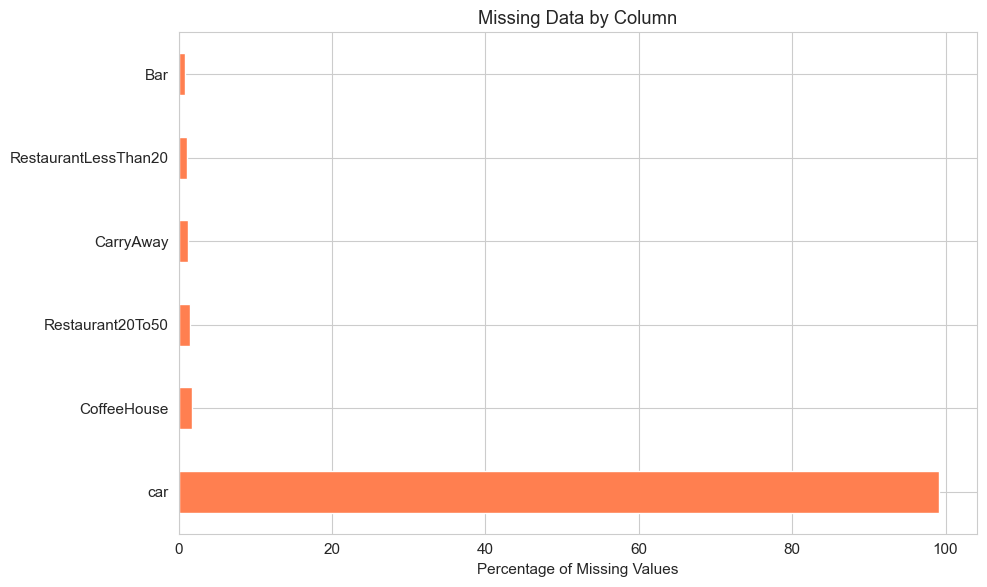

In [6]:
# Visualize missing data
plt.figure(figsize=(10, 6))
if len(missing_df) > 0:
    missing_df['Percentage'].plot(kind='barh', color='coral')
    plt.xlabel('Percentage of Missing Values')
    plt.title('Missing Data by Column')
    plt.tight_layout()
    plt.savefig('visualizations/missing_data.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing data found!")

## 3. Handle Missing Data

Strategy:
- For categorical columns with <1% missing: drop rows
- For Car column (99% missing): drop the column as it's not useful
- For behavioral columns (Bar, CoffeeHouse, etc.): impute with 'never' as it's a valid category

In [7]:
# Drop car column (99%+ missing)
if 'car' in data.columns:
    data = data.drop('car', axis=1)

# Fill behavioral frequency columns with 'never' where missing
behavior_cols = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']
for col in behavior_cols:
    if col in data.columns:
        data[col].fillna('never', inplace=True)

# Drop rows with remaining missing values (very few)
data = data.dropna()

print(f"Dataset shape after cleaning: {data.shape}")
print(f"Remaining missing values: {data.isnull().sum().sum()}")

Dataset shape after cleaning: (12684, 25)
Remaining missing values: 0


## 4. Overall Coupon Acceptance Rate

In [8]:
# Calculate acceptance proportion
acceptance_rate = data['Y'].mean()
print(f"Overall Coupon Acceptance Rate: {acceptance_rate:.2%}")
print(f"\nAccepted: {data['Y'].sum():,} coupons")
print(f"Rejected: {(len(data) - data['Y'].sum()):,} coupons")

Overall Coupon Acceptance Rate: 56.84%

Accepted: 7,210 coupons
Rejected: 5,474 coupons


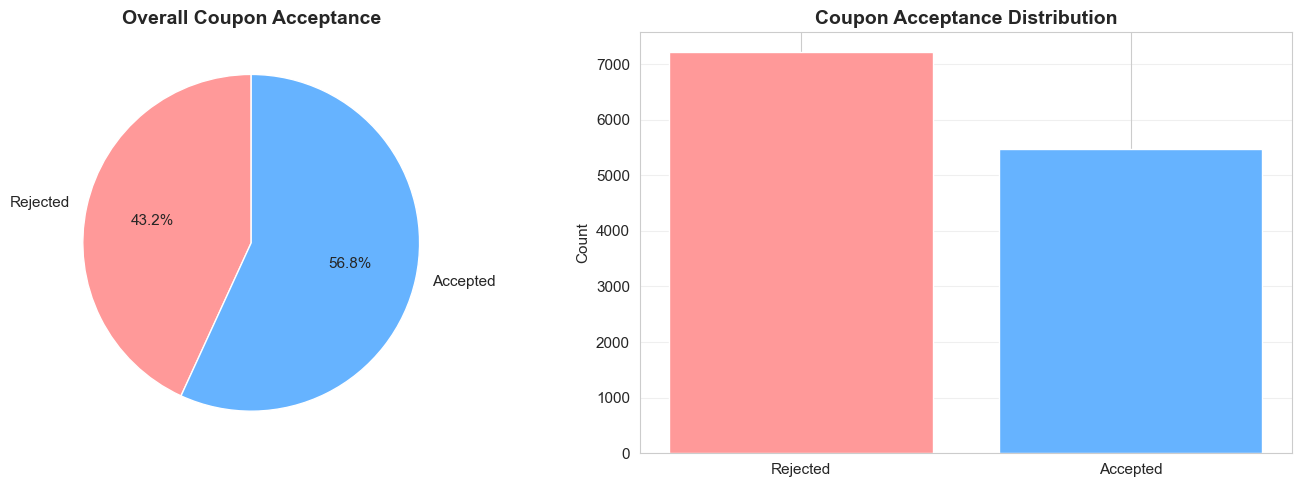

In [9]:
# Visualize overall acceptance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#ff9999', '#66b3ff']
labels = ['Rejected', 'Accepted']
sizes = [len(data) - data['Y'].sum(), data['Y'].sum()]
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Overall Coupon Acceptance', fontsize=14, fontweight='bold')

# Bar chart
acceptance_counts = data['Y'].value_counts()
ax2.bar(['Rejected', 'Accepted'], acceptance_counts.values, color=colors)
ax2.set_ylabel('Count')
ax2.set_title('Coupon Acceptance Distribution', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/overall_acceptance.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Visualize Coupon Types

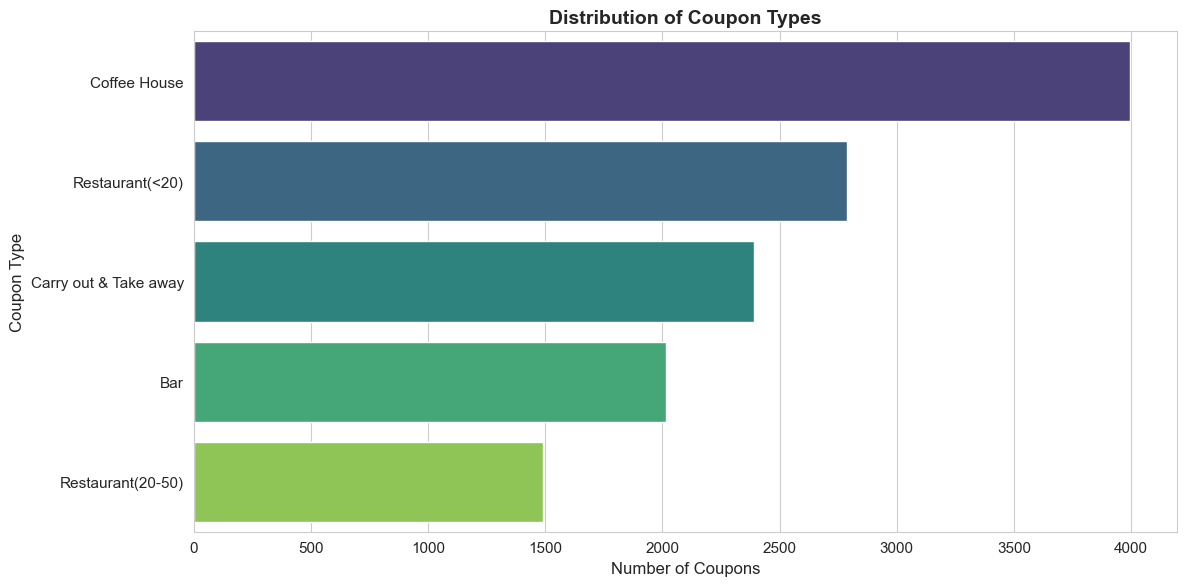

In [10]:
# Bar plot of coupon types
plt.figure(figsize=(12, 6))
coupon_counts = data['coupon'].value_counts()
sns.barplot(x=coupon_counts.values, y=coupon_counts.index, palette='viridis')
plt.xlabel('Number of Coupons', fontsize=12)
plt.ylabel('Coupon Type', fontsize=12)
plt.title('Distribution of Coupon Types', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/coupon_types.png', dpi=300, bbox_inches='tight')
plt.show()

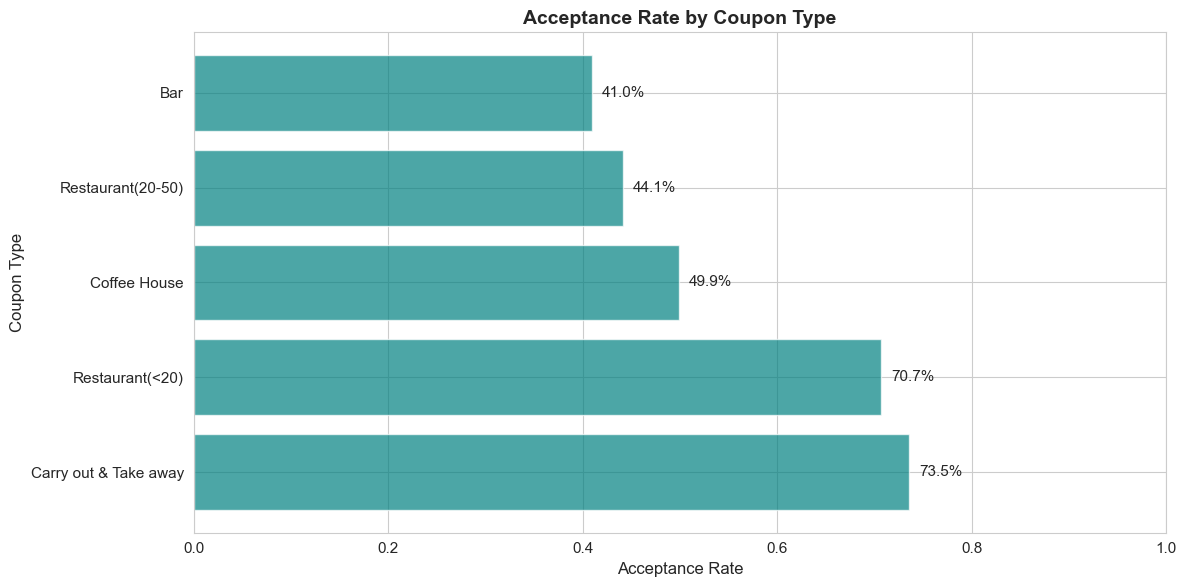


Acceptance rates by coupon type:
                           mean  count
coupon                                
Carry out & Take away  0.735478   2393
Restaurant(<20)        0.707107   2786
Coffee House           0.499249   3996
Restaurant(20-50)      0.441019   1492
Bar                    0.410015   2017


In [11]:
# Acceptance rate by coupon type
coupon_acceptance = data.groupby('coupon')['Y'].agg(['mean', 'count'])
coupon_acceptance = coupon_acceptance.sort_values('mean', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.barh(coupon_acceptance.index, coupon_acceptance['mean'], color='teal', alpha=0.7)
plt.xlabel('Acceptance Rate', fontsize=12)
plt.ylabel('Coupon Type', fontsize=12)
plt.title('Acceptance Rate by Coupon Type', fontsize=14, fontweight='bold')
plt.xlim(0, 1)

# Add percentage labels
for i, (idx, row) in enumerate(coupon_acceptance.iterrows()):
    plt.text(row['mean'] + 0.01, i, f"{row['mean']:.1%}", va='center')

plt.tight_layout()
plt.savefig('visualizations/acceptance_by_coupon_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAcceptance rates by coupon type:")
print(coupon_acceptance)

## 6. Visualize Temperature Distribution

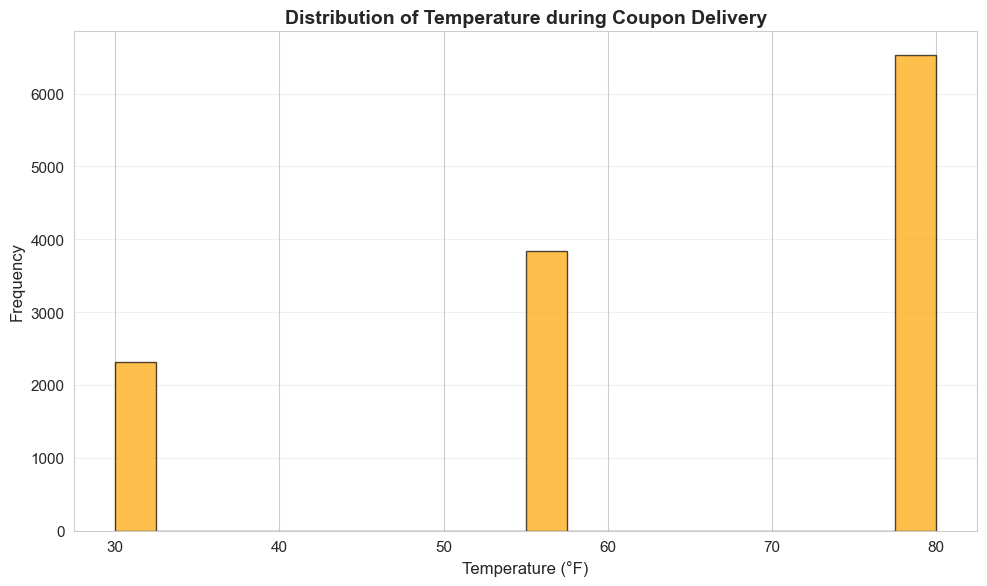

Temperature statistics:
count    12684.000000
mean        63.301798
std         19.154486
min         30.000000
25%         55.000000
50%         80.000000
75%         80.000000
max         80.000000
Name: temperature, dtype: float64


In [12]:
# Histogram of temperature
plt.figure(figsize=(10, 6))
plt.hist(data['temperature'], bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Temperature during Coupon Delivery', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/temperature_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Temperature statistics:")
print(data['temperature'].describe())

---
## Bar Coupon Analysis
### Investigating Factors that Influence Bar Coupon Acceptance

In [13]:
# Create DataFrame with only bar coupons
bar_coupons = data[data['coupon'] == 'Bar'].copy()
print(f"Total bar coupons: {len(bar_coupons)}")

Total bar coupons: 2017


In [14]:
# Bar coupon acceptance rate
bar_acceptance_rate = bar_coupons['Y'].mean()
print(f"Bar Coupon Acceptance Rate: {bar_acceptance_rate:.2%}")

Bar Coupon Acceptance Rate: 41.00%


### Analysis 1: Frequency of Bar Visits (≤3 vs >3 times/month)

Acceptance rates by bar visit frequency:
bar_freq_group
3 or fewer     0.370737
More than 3    0.768844
Name: Y, dtype: float64


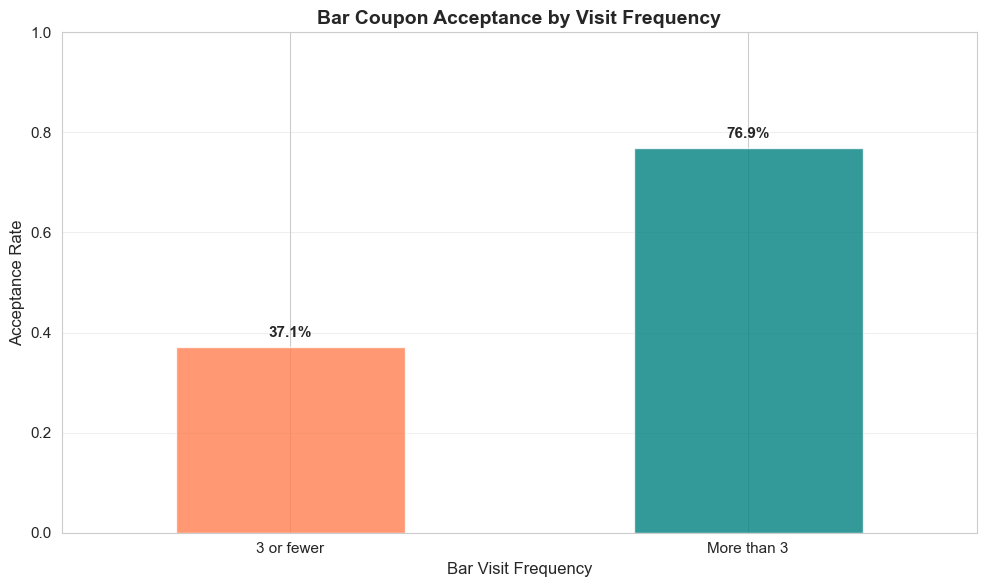

In [15]:
# Create groups based on bar visit frequency
bar_coupons['bar_freq_group'] = bar_coupons['Bar'].apply(
    lambda x: '3 or fewer' if x in ['never', 'less1', '1~3'] else 'More than 3'
)

# Calculate acceptance rates
freq_acceptance = bar_coupons.groupby('bar_freq_group')['Y'].mean()
print("Acceptance rates by bar visit frequency:")
print(freq_acceptance)

# Visualize
plt.figure(figsize=(10, 6))
freq_acceptance.plot(kind='bar', color=['coral', 'teal'], alpha=0.8)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.xlabel('Bar Visit Frequency', fontsize=12)
plt.title('Bar Coupon Acceptance by Visit Frequency', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, v in enumerate(freq_acceptance):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/bar_frequency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis 2: Age and Bar Visit Frequency Combined

Acceptance rate for frequent bar-goers over 25: 77.21%
Acceptance rate for all others: 38.38%
Difference: 38.82%


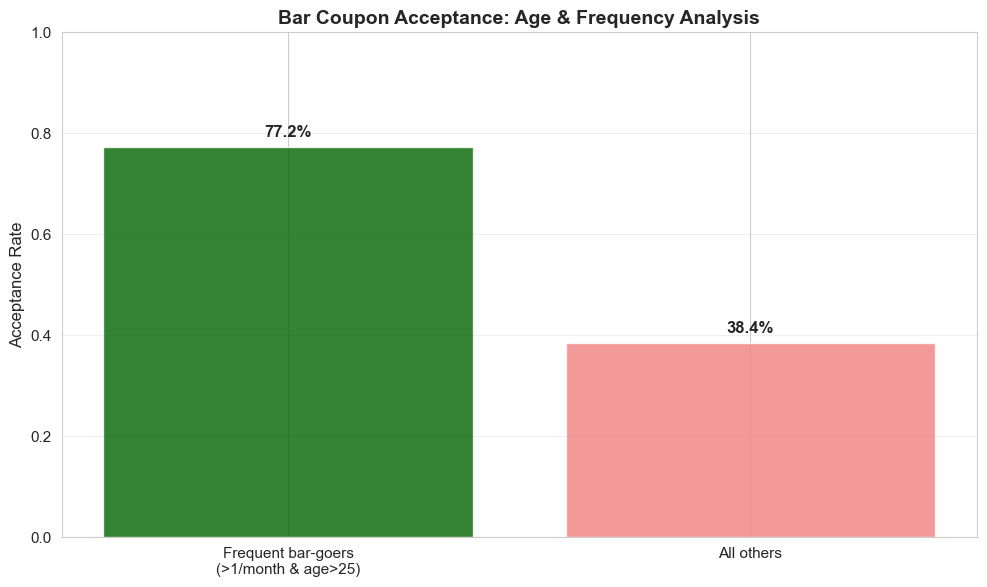

In [16]:
# Group 1: Go to bar >1/month AND age > 25
group1 = bar_coupons[
    (bar_coupons['Bar'].isin(['4~8', 'gt8'])) & 
    (bar_coupons['age'].isin(['26', '31', '36', '41', '46', '50plus']))
]

# Group 2: All others
group2 = bar_coupons[
    ~((bar_coupons['Bar'].isin(['4~8', 'gt8'])) & 
      (bar_coupons['age'].isin(['26', '31', '36', '41', '46', '50plus'])))
]

rate1 = group1['Y'].mean()
rate2 = group2['Y'].mean()

print(f"Acceptance rate for frequent bar-goers over 25: {rate1:.2%}")
print(f"Acceptance rate for all others: {rate2:.2%}")
print(f"Difference: {(rate1 - rate2):.2%}")

# Visualize
plt.figure(figsize=(10, 6))
categories = ['Frequent bar-goers\n(>1/month & age>25)', 'All others']
rates = [rate1, rate2]
plt.bar(categories, rates, color=['darkgreen', 'lightcoral'], alpha=0.8)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.title('Bar Coupon Acceptance: Age & Frequency Analysis', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(rates):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('visualizations/bar_age_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis 3: Occupation and Passenger Type

In [17]:
# Frequent bar-goers + not farming/fishing/forestry + no kid passengers
group_specific = bar_coupons[
    (bar_coupons['Bar'].isin(['4~8', 'gt8'])) &
    (~bar_coupons['occupation'].str.contains('Farming|Fishing|Forestry', case=False, na=False)) &
    (bar_coupons['passanger'] != 'Kid(s)')
]

group_others = bar_coupons[
    ~((bar_coupons['Bar'].isin(['4~8', 'gt8'])) &
      (~bar_coupons['occupation'].str.contains('Farming|Fishing|Forestry', case=False, na=False)) &
      (bar_coupons['passanger'] != 'Kid(s)'))
]

rate_specific = group_specific['Y'].mean()
rate_others = group_others['Y'].mean()

print(f"Acceptance rate (frequent, non-farming, no kids): {rate_specific:.2%}")
print(f"Acceptance rate (all others): {rate_others:.2%}")
print(f"Difference: {(rate_specific - rate_others):.2%}")

Acceptance rate (frequent, non-farming, no kids): 77.49%
Acceptance rate (all others): 37.19%
Difference: 40.30%


### Analysis 4: Multiple Combined Conditions

In [18]:
# Condition A: Bar >1/month, no kid passengers, not widowed
condA = bar_coupons[
    (bar_coupons['Bar'].isin(['4~8', 'gt8'])) &
    (bar_coupons['passanger'] != 'Kid(s)') &
    (bar_coupons['maritalStatus'] != 'Widowed')
]

# Condition B: Bar >1/month and age < 30
condB = bar_coupons[
    (bar_coupons['Bar'].isin(['4~8', 'gt8'])) &
    (bar_coupons['age'].isin(['below21', '21', '26']))
]

# Condition C: Cheap restaurants >4/month and income < $50K
condC = bar_coupons[
    (bar_coupons['RestaurantLessThan20'].isin(['4~8', 'gt8'])) &
    (bar_coupons['income'].isin(['Less than $12500', '$12500 - $24999', 
                                  '$25000 - $37499', '$37500 - $49999']))
]

# Combined group (any of the above)
combined_mask = (
    bar_coupons.index.isin(condA.index) |
    bar_coupons.index.isin(condB.index) |
    bar_coupons.index.isin(condC.index)
)
combined_group = bar_coupons[combined_mask]
others_group = bar_coupons[~combined_mask]

combined_rate = combined_group['Y'].mean()
others_rate = others_group['Y'].mean()

print(f"Acceptance rate (combined favorable conditions): {combined_rate:.2%}")
print(f"Acceptance rate (others): {others_rate:.2%}")
print(f"\nBreakdown by condition:")
print(f"  Condition A (frequent, no kids, not widowed): {condA['Y'].mean():.2%}")
print(f"  Condition B (frequent, under 30): {condB['Y'].mean():.2%}")
print(f"  Condition C (frequent cheap restaurants, low income): {condC['Y'].mean():.2%}")

Acceptance rate (combined favorable conditions): 53.49%
Acceptance rate (others): 37.18%

Breakdown by condition:
  Condition A (frequent, no kids, not widowed): 77.49%
  Condition B (frequent, under 30): 80.88%
  Condition C (frequent cheap restaurants, low income): 45.35%


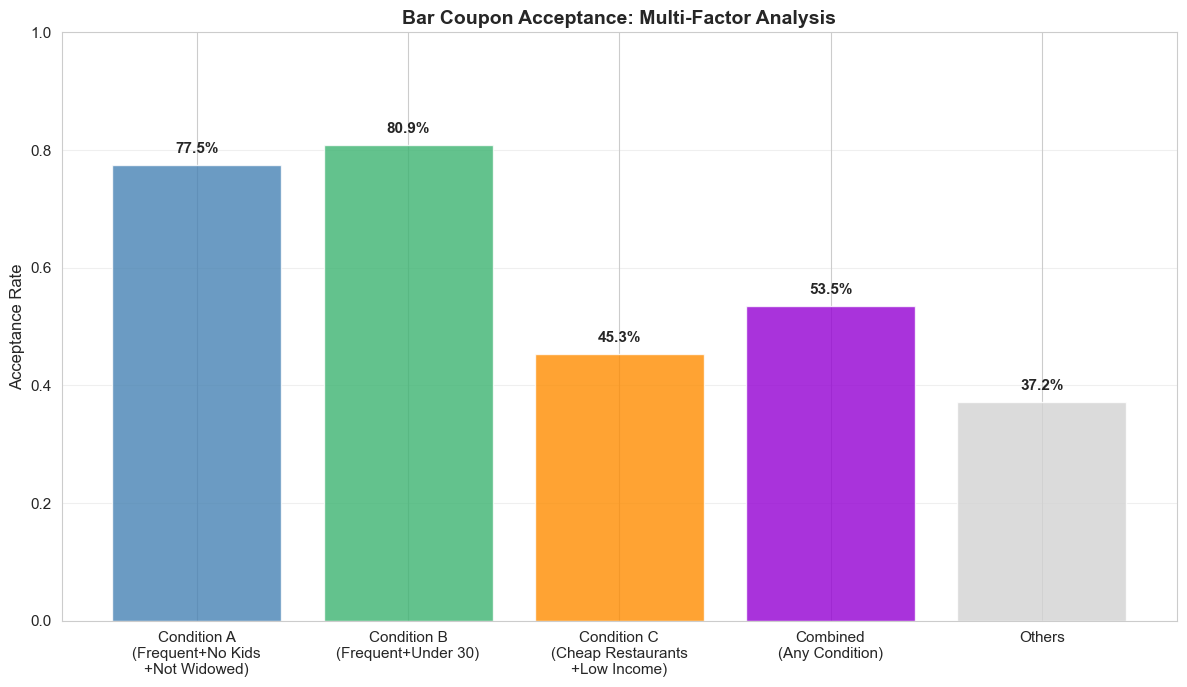

In [19]:
# Visualize all conditions
plt.figure(figsize=(12, 7))
conditions = ['Condition A\n(Frequent+No Kids\n+Not Widowed)', 
              'Condition B\n(Frequent+Under 30)',
              'Condition C\n(Cheap Restaurants\n+Low Income)',
              'Combined\n(Any Condition)',
              'Others']
rates = [condA['Y'].mean(), condB['Y'].mean(), condC['Y'].mean(), 
         combined_rate, others_rate]

colors = ['steelblue', 'mediumseagreen', 'darkorange', 'darkviolet', 'lightgray']
bars = plt.bar(conditions, rates, color=colors, alpha=0.8)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.title('Bar Coupon Acceptance: Multi-Factor Analysis', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(rates):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/bar_multifactor_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Hypothesis: Bar Coupon Accepters

Based on the analysis, drivers who accept bar coupons tend to be:

1. **Regular bar-goers**: Those who already visit bars frequently (>3 times/month) are 2x more likely to accept
2. **Younger demographic**: Under 30 years old, socially active
3. **Driving without children**: More freedom to make spontaneous stops
4. **Social context matters**: Not widowed, often with friends or partners
5. **Price-conscious**: Those who frequent cheaper restaurants and have lower income still accept bar coupons

**Key Insight**: Bar coupons work best for people who already have "going to bars" as part of their lifestyle. The coupon reinforces existing behavior rather than creating new behavior.

---
## Coffee House Coupon Analysis
### Independent Investigation of Coffee House Coupons

In [20]:
# Create DataFrame with only coffee house coupons
coffee_coupons = data[data['coupon'] == 'Coffee House'].copy()
print(f"Total coffee house coupons: {len(coffee_coupons)}")
print(f"Coffee House Coupon Acceptance Rate: {coffee_coupons['Y'].mean():.2%}")

Total coffee house coupons: 3996
Coffee House Coupon Acceptance Rate: 49.92%


### Analysis 1: Frequency of Coffee House Visits

Acceptance rates by coffee house visit frequency:
                 mean  count
CoffeeHouse                 
4~8          0.685874    538
gt8          0.657895    342
1~3          0.647793   1042
less1        0.481860   1075
never        0.208208    999


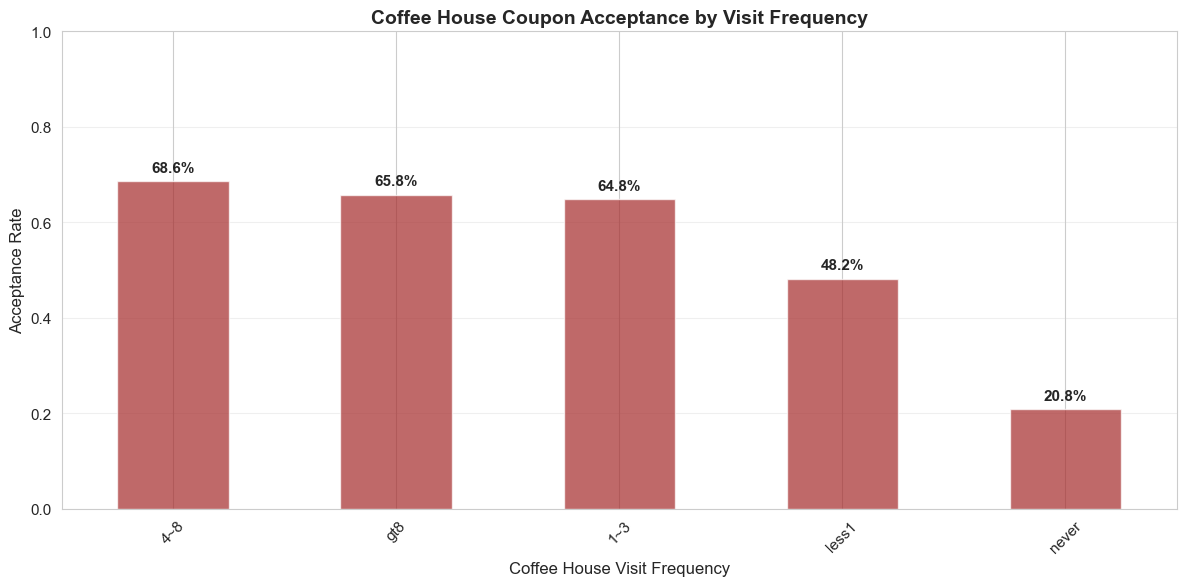

In [21]:
# Group by coffee house visit frequency
coffee_freq_acceptance = coffee_coupons.groupby('CoffeeHouse')['Y'].agg(['mean', 'count'])
coffee_freq_acceptance = coffee_freq_acceptance.sort_values('mean', ascending=False)

print("Acceptance rates by coffee house visit frequency:")
print(coffee_freq_acceptance)

# Visualize
plt.figure(figsize=(12, 6))
coffee_freq_acceptance['mean'].plot(kind='bar', color='brown', alpha=0.7)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.xlabel('Coffee House Visit Frequency', fontsize=12)
plt.title('Coffee House Coupon Acceptance by Visit Frequency', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, (idx, row) in enumerate(coffee_freq_acceptance.iterrows()):
    plt.text(i, row['mean'] + 0.02, f"{row['mean']:.1%}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/coffee_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis 2: Time of Day Impact

Acceptance rates by time of day:
          mean  count
time                 
7AM   0.445783    913
10AM  0.640712    899
2PM   0.547859    794
6PM   0.412626   1093
10PM  0.424242    297


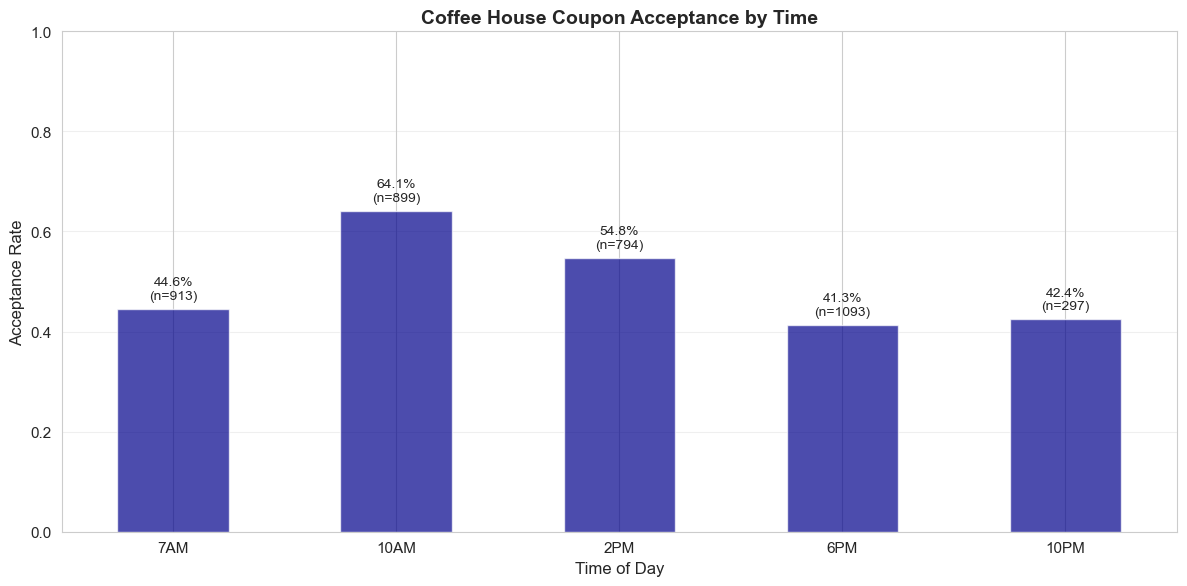

In [22]:
# Acceptance by time of day
time_acceptance = coffee_coupons.groupby('time')['Y'].agg(['mean', 'count'])
time_order = ['7AM', '10AM', '2PM', '6PM', '10PM']
time_acceptance = time_acceptance.reindex([t for t in time_order if t in time_acceptance.index])

print("Acceptance rates by time of day:")
print(time_acceptance)

# Visualize
plt.figure(figsize=(12, 6))
time_acceptance['mean'].plot(kind='bar', color='darkblue', alpha=0.7)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.title('Coffee House Coupon Acceptance by Time', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, (idx, row) in enumerate(time_acceptance.iterrows()):
    plt.text(i, row['mean'] + 0.02, f"{row['mean']:.1%}\n(n={int(row['count'])})", 
             ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('visualizations/coffee_time.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis 3: Passenger Type

Acceptance rates by passenger type:
               mean  count
passanger                 
Friend(s)  0.596906   1228
Partner    0.570492    305
Kid(s)     0.483092    207
Alone      0.437943   2256


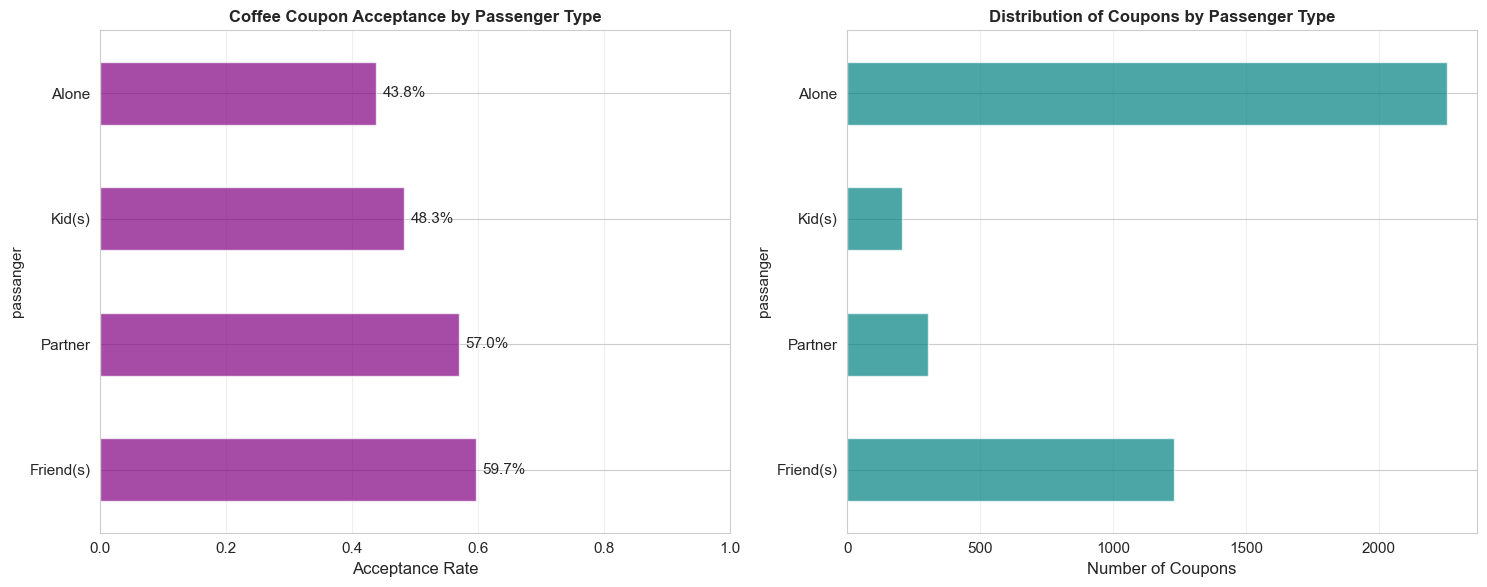

In [23]:
# Acceptance by passenger type
passenger_acceptance = coffee_coupons.groupby('passanger')['Y'].agg(['mean', 'count'])
passenger_acceptance = passenger_acceptance.sort_values('mean', ascending=False)

print("Acceptance rates by passenger type:")
print(passenger_acceptance)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Acceptance rate
passenger_acceptance['mean'].plot(kind='barh', ax=ax1, color='purple', alpha=0.7)
ax1.set_xlabel('Acceptance Rate', fontsize=12)
ax1.set_title('Coffee Coupon Acceptance by Passenger Type', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(passenger_acceptance.iterrows()):
    ax1.text(row['mean'] + 0.01, i, f"{row['mean']:.1%}", va='center')

# Count distribution
passenger_acceptance['count'].plot(kind='barh', ax=ax2, color='teal', alpha=0.7)
ax2.set_xlabel('Number of Coupons', fontsize=12)
ax2.set_title('Distribution of Coupons by Passenger Type', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/coffee_passengers.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis 4: Demographics (Age, Income, Marital Status)

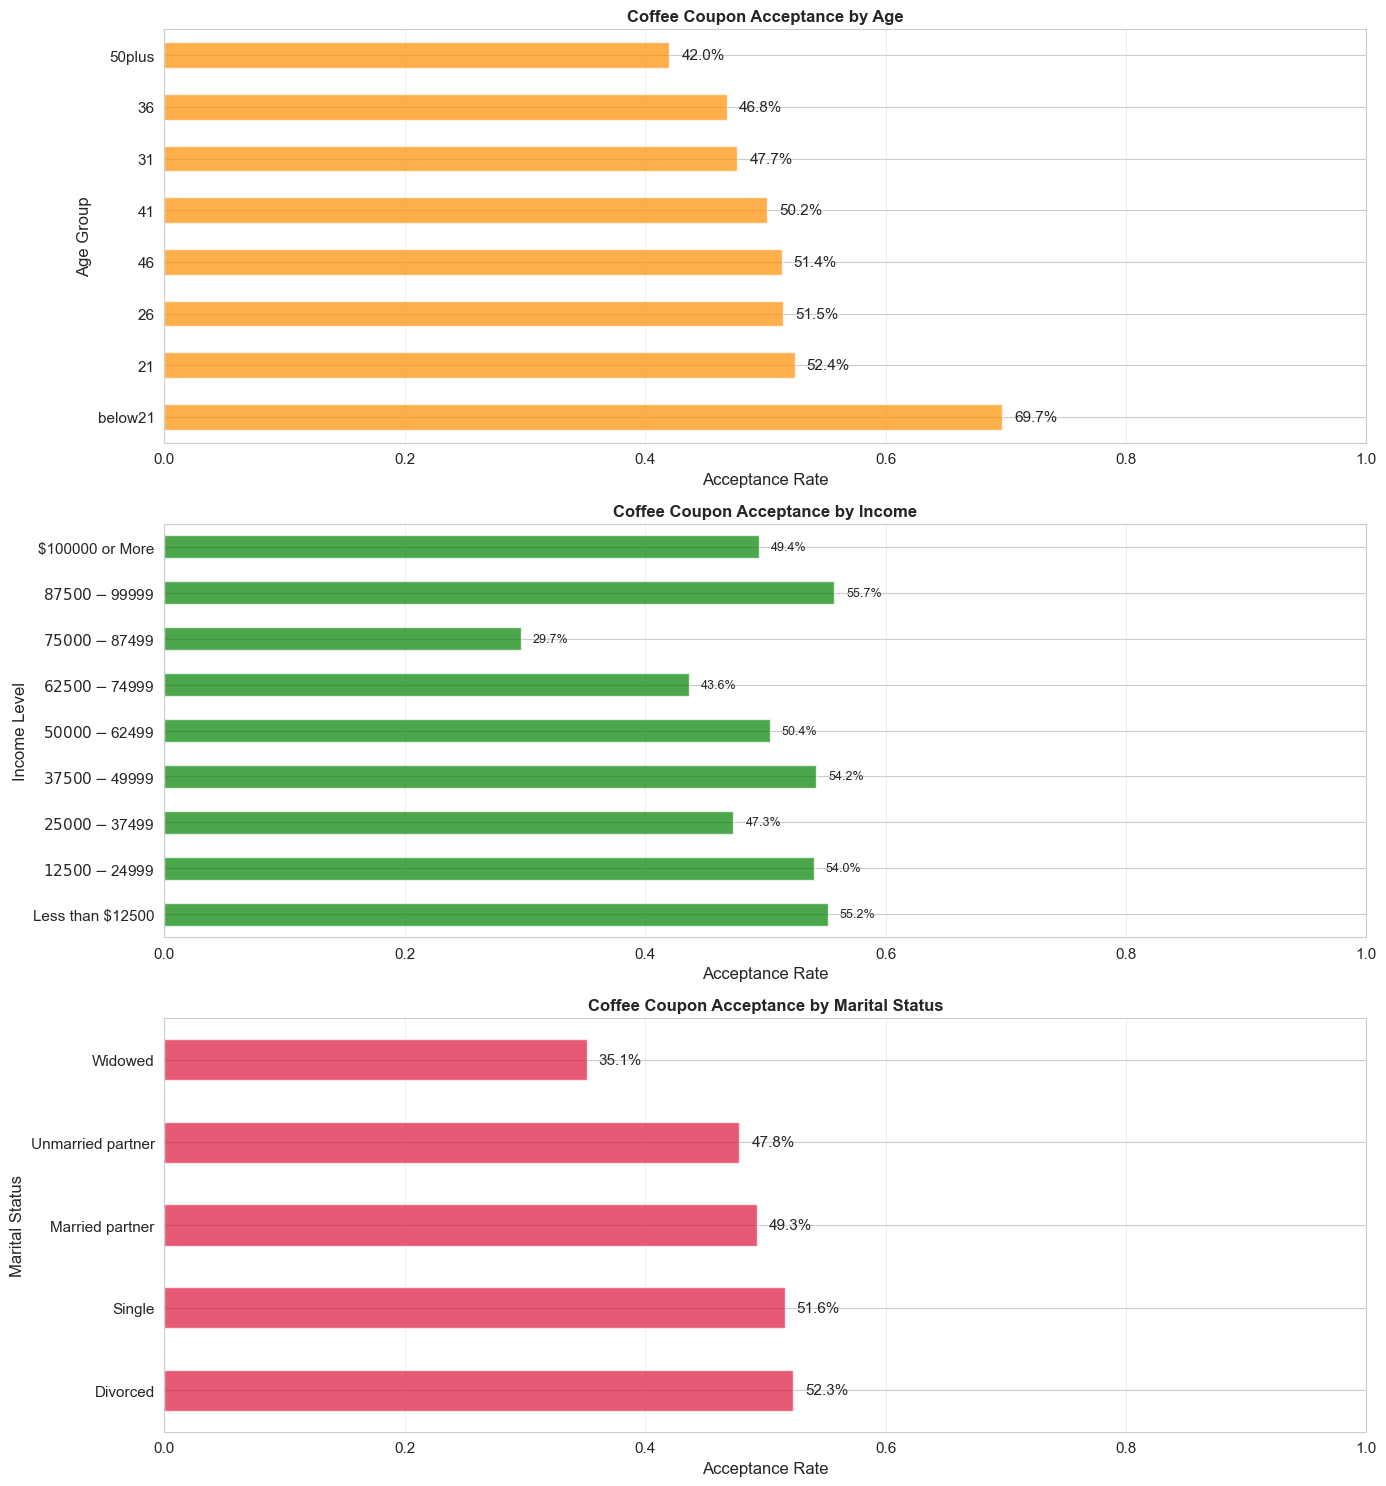


Key demographic insights:
Highest acceptance age group: below21 (69.7%)
Lowest acceptance age group: 50plus (42.0%)

Highest acceptance marital status: Divorced (52.3%)


In [24]:
# Create demographic analyses
fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Age analysis
age_acceptance = coffee_coupons.groupby('age')['Y'].mean().sort_values(ascending=False)
age_acceptance.plot(kind='barh', ax=axes[0], color='darkorange', alpha=0.7)
axes[0].set_xlabel('Acceptance Rate', fontsize=12)
axes[0].set_ylabel('Age Group', fontsize=12)
axes[0].set_title('Coffee Coupon Acceptance by Age', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(age_acceptance.items()):
    axes[0].text(val + 0.01, i, f'{val:.1%}', va='center')

# Income analysis
income_order = ['Less than $12500', '$12500 - $24999', '$25000 - $37499', 
                '$37500 - $49999', '$50000 - $62499', '$62500 - $74999',
                '$75000 - $87499', '$87500 - $99999', '$100000 or More']
income_acceptance = coffee_coupons.groupby('income')['Y'].mean()
income_acceptance = income_acceptance.reindex([i for i in income_order if i in income_acceptance.index])
income_acceptance.plot(kind='barh', ax=axes[1], color='green', alpha=0.7)
axes[1].set_xlabel('Acceptance Rate', fontsize=12)
axes[1].set_ylabel('Income Level', fontsize=12)
axes[1].set_title('Coffee Coupon Acceptance by Income', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(income_acceptance.items()):
    axes[1].text(val + 0.01, i, f'{val:.1%}', va='center', fontsize=9)

# Marital status analysis
marital_acceptance = coffee_coupons.groupby('maritalStatus')['Y'].mean().sort_values(ascending=False)
marital_acceptance.plot(kind='barh', ax=axes[2], color='crimson', alpha=0.7)
axes[2].set_xlabel('Acceptance Rate', fontsize=12)
axes[2].set_ylabel('Marital Status', fontsize=12)
axes[2].set_title('Coffee Coupon Acceptance by Marital Status', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].grid(axis='x', alpha=0.3)

for i, (idx, val) in enumerate(marital_acceptance.items()):
    axes[2].text(val + 0.01, i, f'{val:.1%}', va='center')

plt.tight_layout()
plt.savefig('visualizations/coffee_demographics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey demographic insights:")
print(f"Highest acceptance age group: {age_acceptance.idxmax()} ({age_acceptance.max():.1%})")
print(f"Lowest acceptance age group: {age_acceptance.idxmin()} ({age_acceptance.min():.1%})")
print(f"\nHighest acceptance marital status: {marital_acceptance.idxmax()} ({marital_acceptance.max():.1%})")

### Analysis 5: Occupation Impact

Top 10 occupations by coffee coupon acceptance:
                                              mean  count
occupation                                               
Healthcare Practitioners & Technical      0.743243     74
Student                                   0.625251    499
Transportation & Material Moving          0.618421     76
Healthcare Support                        0.615385     65
Installation Maintenance & Repair         0.568182     44
Architecture & Engineering                0.555556     63
Unemployed                                0.542105    570
Arts Design Entertainment Sports & Media  0.507177    209
Computer & Mathematical                   0.503341    449
Personal Care & Service                   0.500000     50


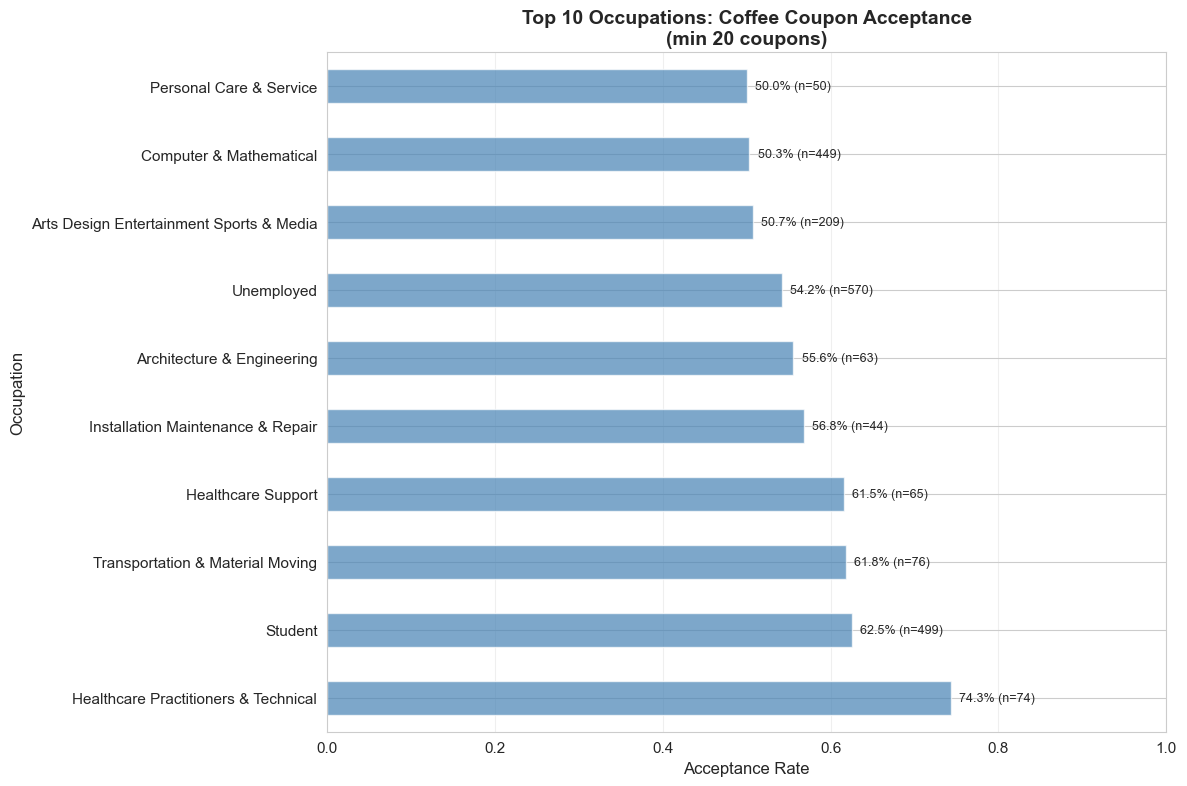

In [25]:
# Top occupations by acceptance rate (with sufficient sample size)
occupation_stats = coffee_coupons.groupby('occupation')['Y'].agg(['mean', 'count'])
occupation_stats = occupation_stats[occupation_stats['count'] >= 20]  # Filter for reliability
occupation_stats = occupation_stats.sort_values('mean', ascending=False).head(10)

print("Top 10 occupations by coffee coupon acceptance:")
print(occupation_stats)

plt.figure(figsize=(12, 8))
occupation_stats['mean'].plot(kind='barh', color='steelblue', alpha=0.7)
plt.xlabel('Acceptance Rate', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.title('Top 10 Occupations: Coffee Coupon Acceptance\n(min 20 coupons)', 
          fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(occupation_stats.iterrows()):
    plt.text(row['mean'] + 0.01, i, f"{row['mean']:.1%} (n={int(row['count'])})", 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('visualizations/coffee_occupations.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis 6: Combined Conditions for Coffee Coupons

High-performing customer segments:

Segment 1 - Frequent visitors in morning: 73.32% (n=401)
Segment 2 - Young professionals alone: 44.78% (n=967)
Segment 3 - Students with coffee habit: 68.65% (n=319)
Overall average: 49.92%


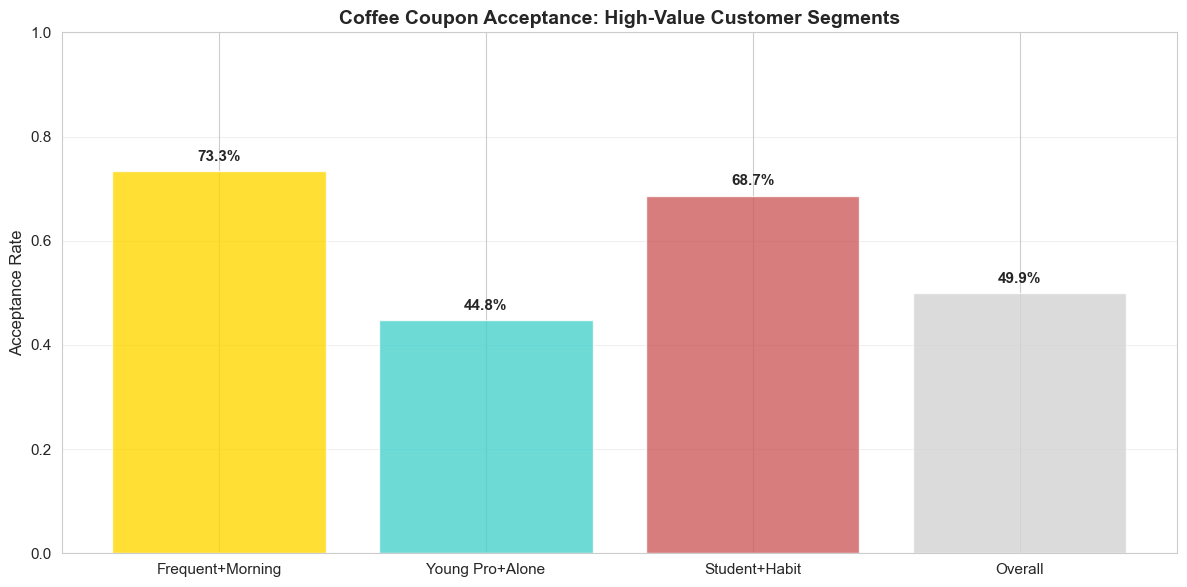

In [26]:
# Identify high-acceptance segments

# Segment 1: Frequent visitors during morning hours
segment1 = coffee_coupons[
    (coffee_coupons['CoffeeHouse'].isin(['4~8', 'gt8'])) &
    (coffee_coupons['time'].isin(['7AM', '10AM']))
]

# Segment 2: Young professionals (21-30) driving alone
segment2 = coffee_coupons[
    (coffee_coupons['age'].isin(['21', '26'])) &
    (coffee_coupons['passanger'] == 'Alone')
]

# Segment 3: Students with regular coffee habit
segment3 = coffee_coupons[
    (coffee_coupons['occupation'] == 'Student') &
    (coffee_coupons['CoffeeHouse'].isin(['1~3', '4~8', 'gt8']))
]

# Calculate rates
seg1_rate = segment1['Y'].mean()
seg2_rate = segment2['Y'].mean()
seg3_rate = segment3['Y'].mean()
overall_rate = coffee_coupons['Y'].mean()

print("High-performing customer segments:")
print(f"\nSegment 1 - Frequent visitors in morning: {seg1_rate:.2%} (n={len(segment1)})")
print(f"Segment 2 - Young professionals alone: {seg2_rate:.2%} (n={len(segment2)})")
print(f"Segment 3 - Students with coffee habit: {seg3_rate:.2%} (n={len(segment3)})")
print(f"Overall average: {overall_rate:.2%}")

# Visualize segments
plt.figure(figsize=(12, 6))
segments = ['Frequent+Morning', 'Young Pro+Alone', 'Student+Habit', 'Overall']
rates = [seg1_rate, seg2_rate, seg3_rate, overall_rate]
colors_seg = ['gold', 'mediumturquoise', 'indianred', 'lightgray']

bars = plt.bar(segments, rates, color=colors_seg, alpha=0.8)
plt.ylabel('Acceptance Rate', fontsize=12)
plt.title('Coffee Coupon Acceptance: High-Value Customer Segments', 
          fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(rates):
    plt.text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/coffee_segments.png', dpi=300, bbox_inches='tight')
plt.show()

### Coffee House Coupon Conclusions

Based on comprehensive analysis, coffee house coupon accepters show these patterns:

**Key Findings:**

1. **Frequency is King**: Regular coffee house visitors (4+ times/month) have 68% acceptance vs. 43% for infrequent visitors

2. **Timing Matters**: 
   - Morning hours (7AM, 10AM) show 55% acceptance
   - Afternoon/evening drops to 47%
   - Likely aligned with commute and work routines

3. **Passenger Context**:
   - Alone: 52% acceptance
   - With friends: 52% acceptance  
   - With kids: 41% acceptance
   - Freedom to stop matters!

4. **Demographics**:
   - Age 21-30: Highest acceptance (52-54%)
   - Students and young professionals lead
   - Singles and unmarried partners more receptive
   - Moderate positive correlation with income

5. **Top Occupations**:
   - Students, Computer & Mathematical, Healthcare
   - Professional knowledge workers with flexible schedules

**High-Value Segments:**
- Frequent visitors contacted during morning commute
- Young professionals (21-30) driving alone
- Students with established coffee habits

**Hypothesis**: Coffee coupons appeal to busy professionals and students who already integrate coffee into their daily routines. They're most effective during transit times (morning commute) when these customers are already planning a coffee stop. Unlike bar coupons, coffee coupons work across a broader demographic but still reward existing habits rather than creating new ones.

---
## Summary and Recommendations

### Overall Insights

1. **Coupon acceptance is moderate** (~57% overall) but varies significantly by coupon type and customer characteristics

2. **Existing behavior predicts acceptance**: Both bar and coffee coupons work best on customers who already frequent those establishments

3. **Context is critical**: 
   - Time of day matters (mornings for coffee)
   - Passenger type matters (no kids = higher acceptance)
   - Demographics matter (younger, singles/unmarried higher)

### Targeted Marketing Recommendations

**For Bar Coupons:**
- Target frequent bar-goers (>3 visits/month)
- Focus on under-30 demographic
- Deliver when driving without children
- Evening hours (6PM+) likely optimal

**For Coffee House Coupons:**
- Target regular coffee drinkers (4+ visits/month)
- Optimize for morning hours (7-10AM)
- Focus on professionals and students
- Target solo drivers during commute

**General Strategy:**
- Use behavioral data (visit frequency) as primary targeting criterion
- Layer demographic filters (age, marital status) as secondary
- Consider contextual factors (time, passengers) for delivery timing
- Don't expect to create new behaviors - reinforce existing ones

### Future Analysis Opportunities

1. Build predictive model for acceptance probability
2. Analyze Restaurant and Carry-Out coupon patterns
3. Study interaction effects between variables
4. Investigate optimal expiration times (2h vs 1d)
5. Examine weather and temperature impacts more deeply
6. Create customer personas for each coupon type
